In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "G2-like"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
2274,orange1.1g038268m,MENVTDTVEISSDDNKSNESGTQAFQKCSSFDLNEEAAMDDAENDN...,260,1
1332,XP_009105367.1,MAENMVNLTKNIIPESTGVILLIDHDAASVASLIPMLKQRSHKDVM...,593,1
4646,Manes.08G062200.1.p,MRDDDSNWFSRWEEELPSPEELMPLSQTLITPDLALAFDIRNPTNT...,324,1
5411,XP_009602580.1,MEPINPSLAGKQRLRWTHELHERFVDAVAQLGGPDRATPKGVLRVM...,295,1
17842,XP_010912156.1,MDSTWIDHPSLSLDLNVGSLRFPDEVSKELPRSPKHEGEEFLMKRE...,304,0


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2776,0.017291,0.000000,0.000000,0.008646,0.002882,0.000000,0.002882,0.002882,0.005764,0.017291,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002882,0.005764,0.0,0.0,0.0
1456,0.032823,0.004376,0.006565,0.006565,0.002188,0.013129,0.004376,0.000000,0.000000,0.000000,...,0.002188,0.000000,0.000000,0.004376,0.006565,0.000000,0.000000,0.0,0.0,0.0
3247,0.025510,0.000000,0.000000,0.025510,0.005102,0.010204,0.005102,0.000000,0.000000,0.000000,...,0.005102,0.005102,0.010204,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2299,0.000000,0.000000,0.000000,0.003413,0.006826,0.003413,0.006826,0.000000,0.000000,0.003413,...,0.000000,0.000000,0.000000,0.003413,0.000000,0.000000,0.000000,0.0,0.0,0.0
3025,0.002045,0.000000,0.008180,0.002045,0.004090,0.004090,0.000000,0.002045,0.006135,0.010225,...,0.004090,0.000000,0.000000,0.002045,0.002045,0.000000,0.000000,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 31s 652ms/step - accuracy: 0.5781 - loss: 0.6929

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5765 - loss: 0.6896   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6302 - loss: 0.6733 - val_accuracy: 0.9237 - val_loss: 0.3600


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.3238

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9275 - loss: 0.2842 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9301 - loss: 0.2538 - val_accuracy: 0.9550 - val_loss: 0.1349


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1641

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1440 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9587 - loss: 0.1319 - val_accuracy: 0.9625 - val_loss: 0.1191


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.1440

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.0918 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.0943 - val_accuracy: 0.9513 - val_loss: 0.1355


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1014

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0871 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9705 - loss: 0.0896 - val_accuracy: 0.9675 - val_loss: 0.1110


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0658

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.0810 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.0806 - val_accuracy: 0.9650 - val_loss: 0.1070


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1373

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9802 - loss: 0.0751 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9795 - loss: 0.0709 - val_accuracy: 0.9650 - val_loss: 0.1067


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0126

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0390 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0496 - val_accuracy: 0.9450 - val_loss: 0.1528


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9375 - loss: 0.1621

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.0881 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9715 - loss: 0.0792 - val_accuracy: 0.9600 - val_loss: 0.1230


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0473

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 0.0613 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9810 - loss: 0.0588 - val_accuracy: 0.9625 - val_loss: 0.1207


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0183

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0298 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0349 - val_accuracy: 0.9613 - val_loss: 0.1264


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9375 - loss: 0.1800

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0838

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.0771 - val_accuracy: 0.9638 - val_loss: 0.1077


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0077

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0337

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0341 - val_accuracy: 0.9600 - val_loss: 0.1515


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0370

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0499

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0463 - val_accuracy: 0.9638 - val_loss: 0.1105


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0107

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0307

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0285 - val_accuracy: 0.9625 - val_loss: 0.1241



[Train Accuracy: 99.12% - Test Accuracy: 96.50%]


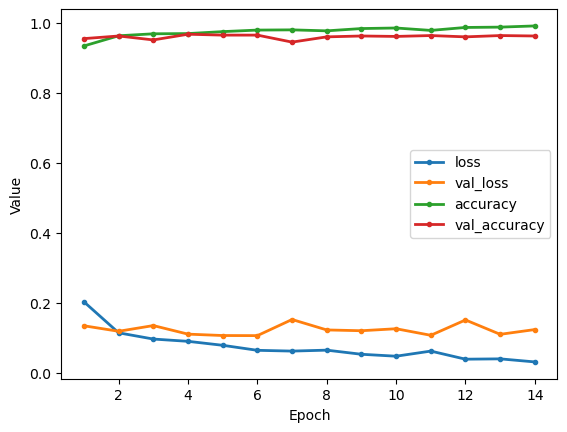

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2776,0.000000,0.0,0.000000,0.002890,0.000000,0.000000,0.000000,0.0,0.0,0.00578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.006579,0.0,0.002193,0.002193,0.000000,0.002193,0.002193,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.000000,0.0,0.000000,0.000000,0.005128,0.000000,0.005128,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8705)
X_test: (1000, 8705)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,228,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,001 (8.67 MB)

 Trainable params: 2,272,001 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 605ms/step - accuracy: 0.4062 - loss: 0.6932

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4750 - loss: 0.6933   

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4837 - loss: 0.6931

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5164 - loss: 0.6924

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5541 - loss: 0.6909

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5885 - loss: 0.6879

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6180 - loss: 0.6826

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6278 - loss: 0.6799 - val_accuracy: 0.9712 - val_loss: 0.3797


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.4067

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9845 - loss: 0.3462 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9848 - loss: 0.3066

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.2737

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9837 - loss: 0.2482

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9837 - loss: 0.2274

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9838 - loss: 0.2103

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9839 - loss: 0.2066 - val_accuracy: 0.9800 - val_loss: 0.0571


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0132

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9921 - loss: 0.0271 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9941 - loss: 0.0210

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0196

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0191

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0187

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0183

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9950 - loss: 0.0181 - val_accuracy: 0.9762 - val_loss: 0.0678


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0036

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0056 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0059

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0069

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0074

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0076

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0076

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 0.9812 - val_loss: 0.0644


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0043

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0031 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0025

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9762 - val_loss: 0.0948


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.3132e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027     

15/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0028

22/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0027

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0025 - val_accuracy: 0.9825 - val_loss: 0.0705


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0052

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0015

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9750 - val_loss: 0.0910


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.8499e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.3459e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6278e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5407e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.2347e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0225e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.8442e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.7689e-04 - val_accuracy: 0.9812 - val_loss: 0.0739


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1935e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9250e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8216e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8063e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7288e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6611e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5916e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5306e-04 - val_accuracy: 0.9762 - val_loss: 0.0905


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.8867e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8607e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5354e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6755e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8284e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1658e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5352e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6984e-04 - val_accuracy: 0.9825 - val_loss: 0.0808


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.7363e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9025e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1238e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1806e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1814e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1796e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1567e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1479e-04 - val_accuracy: 0.9762 - val_loss: 0.1027


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.3555e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3500e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2487e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1128e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0025e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9100e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8375e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8211e-04 - val_accuracy: 0.9775 - val_loss: 0.0989


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.3947e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0319e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8688e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7189e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6059e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5132e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4572e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4397e-04 - val_accuracy: 0.9775 - val_loss: 0.1023


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.0200e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.1083e-05 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8292e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5602e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6341e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5693e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0285e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0507e-04 - val_accuracy: 0.9762 - val_loss: 0.1194


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.6887e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6812e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9048e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8068e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7162e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6330e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5950e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5866e-04 - val_accuracy: 0.9775 - val_loss: 0.1026


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.9796e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7441e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1143e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7747e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5794e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4222e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3083e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2745e-04 - val_accuracy: 0.9775 - val_loss: 0.1156



[Train Accuracy: 100.00% - Test Accuracy: 97.80%]


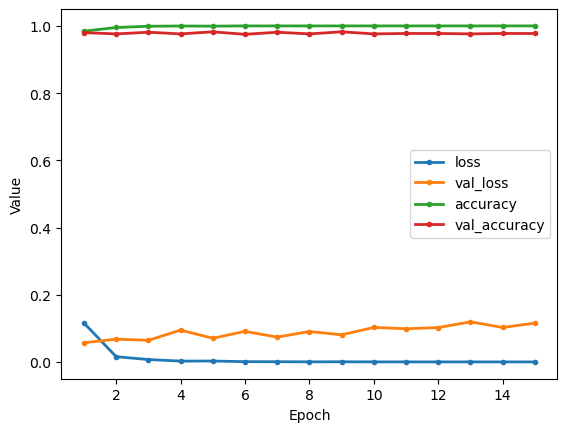

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYY
2776,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,0.002198,0.0,0.002198,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3247,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2299,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,634,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,675,329 (139.91 MB)

 Trainable params: 36,675,329 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 41s 857ms/step - accuracy: 0.4375 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4375 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.4479 - loss: 0.6932

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4570 - loss: 0.6932

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4656 - loss: 0.6931

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.4757 - loss: 0.6931

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.4871 - loss: 0.6931

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.4966 - loss: 0.6930

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5041 - loss: 0.6930

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5109 - loss: 0.6930

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5154 - loss: 0.6929

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.5193 - loss: 0.6929

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5228 - loss: 0.6928

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5254 - loss: 0.6928

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5276 - loss: 0.6927

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5298 - loss: 0.6926

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5323 - loss: 0.6926

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5355 - loss: 0.6925

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5389 - loss: 0.6924

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5424 - loss: 0.6923

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5459 - loss: 0.6922

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5492 - loss: 0.6921

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5528 - loss: 0.6920

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5565 - loss: 0.6919

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5603 - loss: 0.6917

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5638 - loss: 0.6916

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.5671 - loss: 0.6914

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5704 - loss: 0.6913

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.5738 - loss: 0.6911

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5773 - loss: 0.6909

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5809 - loss: 0.6907

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5844 - loss: 0.6905

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5881 - loss: 0.6902

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5917 - loss: 0.6900

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5953 - loss: 0.6897

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5989 - loss: 0.6894

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6025 - loss: 0.6891

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6060 - loss: 0.6887

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6095 - loss: 0.6884

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6129 - loss: 0.6880

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6162 - loss: 0.6875

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6196 - loss: 0.6871

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6228 - loss: 0.6866

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6261 - loss: 0.6861

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6292 - loss: 0.6856

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6324 - loss: 0.6850

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6354 - loss: 0.6844

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6385 - loss: 0.6837

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6414 - loss: 0.6830

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6443 - loss: 0.6823

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 0.6471 - loss: 0.6815 - val_accuracy: 0.9400 - val_loss: 0.4525


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - accuracy: 0.9844 - loss: 0.4141

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9766 - loss: 0.4112 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9757 - loss: 0.4071

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9730 - loss: 0.4047

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9715 - loss: 0.4013

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.9715 - loss: 0.3972

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.9717 - loss: 0.3933

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9718 - loss: 0.3892

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9715 - loss: 0.3851

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9709 - loss: 0.3811

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9706 - loss: 0.3768

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9705 - loss: 0.3722

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9705 - loss: 0.3678

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9705 - loss: 0.3632

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 0.9706 - loss: 0.3586

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9707 - loss: 0.3541

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9709 - loss: 0.3495

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9711 - loss: 0.3449

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9713 - loss: 0.3404

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9715 - loss: 0.3360

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9717 - loss: 0.3317

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9720 - loss: 0.3275

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9722 - loss: 0.3234

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9724 - loss: 0.3194

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9726 - loss: 0.3155

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9728 - loss: 0.3117

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9730 - loss: 0.3080

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9732 - loss: 0.3043

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9734 - loss: 0.3008

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9735 - loss: 0.2974

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9737 - loss: 0.2941

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9738 - loss: 0.2909

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9739 - loss: 0.2877

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9740 - loss: 0.2847

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9742 - loss: 0.2816

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9743 - loss: 0.2787

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9744 - loss: 0.2758

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9746 - loss: 0.2729

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9747 - loss: 0.2701

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9749 - loss: 0.2674

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9750 - loss: 0.2647

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9752 - loss: 0.2621

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9753 - loss: 0.2595

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9755 - loss: 0.2570

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9756 - loss: 0.2546

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9757 - loss: 0.2522

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9759 - loss: 0.2498

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9760 - loss: 0.2476

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9761 - loss: 0.2453

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9763 - loss: 0.2431

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9764 - loss: 0.2410 - val_accuracy: 0.9962 - val_loss: 0.0484


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 1.0000 - loss: 0.0161

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0151 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0143

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0140

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0137

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0133

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0128

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0124

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0120

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0118

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0115

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0114

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0112

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0111

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0110

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0109

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0108

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0107

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0106

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 0.0107

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9999 - loss: 0.0107

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9999 - loss: 0.0107

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9998 - loss: 0.0107

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9998 - loss: 0.0107

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9998 - loss: 0.0107

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0107

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9997 - loss: 0.0106

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9997 - loss: 0.0106

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0106

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0105

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0105

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0104

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9996 - loss: 0.0104

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9995 - loss: 0.0103

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0103

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0102

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0102

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0101

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9995 - loss: 0.0101

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9995 - loss: 0.0100

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9995 - loss: 0.0099

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9995 - loss: 0.0099

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0098

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0098

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0097

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0097

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0096

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0096

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0095

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9995 - loss: 0.0095

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9994 - loss: 0.0094 - val_accuracy: 0.9800 - val_loss: 0.0401


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 1.0000 - loss: 0.0015

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0022 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 0.0023

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0023

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0024

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0025

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0025

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0025

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0025

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0025

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0025

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0025

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0026

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0026

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0026

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0026

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0025

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0025

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0025

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0025

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0025

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0025

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0025

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0025

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0025

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 0.0024

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0025

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0026

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9999 - loss: 0.0026

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 0.0026

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 0.0027

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 0.0027

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 0.0027

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 0.0028

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9999 - loss: 0.0028

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9999 - loss: 0.0028

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9999 - loss: 0.0028

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 0.0029

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 0.0029

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 0.0029

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 0.0029

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 0.0029

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0030

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 0.0030

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 0.0030

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.9887 - val_loss: 0.0292


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 1.0000 - loss: 0.0011

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 0.0014

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 0.0014

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0015

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0014

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0014

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0014

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0014

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0013

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0013

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0013

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0013

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0013

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 0.0013

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0013

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 0.0012

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0012

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0012

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0011

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0011

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9862 - val_loss: 0.0333


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 0.0012

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0010

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0010

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.7208e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 9.2562e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.9520e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.6895e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.4763e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 8.2689e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 8.0783e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.9380e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.8141e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6999e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.6072e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.5257e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.4597e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 7.4059e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.3608e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.3224e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.2916e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.2541e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.2114e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1672e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.1247e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.0856e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 7.0473e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.0093e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.9707e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.9340e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8979e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8610e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.8253e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.7897e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.7545e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.7217e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.6884e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.6549e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.6217e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5907e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5606e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5479e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 6.5342e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5215e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.5079e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4933e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4886e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4831e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4764e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.4687e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.6036e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 6.7333e-04 - val_accuracy: 0.9862 - val_loss: 0.0357


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 2.9540e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.9089e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.9782e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.0606e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.1098e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.1430e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.2675e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.3808e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.5287e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.6893e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.9704e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.1894e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.3710e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.5141e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9999 - loss: 5.9241e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9999 - loss: 7.0888e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9998 - loss: 8.0414e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9998 - loss: 8.8247e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9998 - loss: 9.4725e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9997 - loss: 0.0010    

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0010

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0011

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0011

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9997 - loss: 0.0011

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9996 - loss: 0.0012

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9996 - loss: 0.0012

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9996 - loss: 0.0012

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9996 - loss: 0.0012

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9996 - loss: 0.0012

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9996 - loss: 0.0012

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9996 - loss: 0.0013

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9996 - loss: 0.0013

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9996 - loss: 0.0013

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9996 - loss: 0.0013

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9996 - loss: 0.0013

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9996 - loss: 0.0013

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9996 - loss: 0.0013

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9996 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9812 - val_loss: 0.0392


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 3.4757e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.5179e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.3520e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.3483e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.3356e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.3052e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.2653e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.2334e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.1959e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 3.1561e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.1194e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0860e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0475e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 3.0126e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.9783e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.9533e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.9283e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.9095e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.8979e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.8889e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.8783e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.8754e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 3.1521e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9999 - loss: 3.3929e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9999 - loss: 3.6034e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9999 - loss: 3.7897e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 3.9538e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 4.1404e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9999 - loss: 4.3364e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9998 - loss: 4.5109e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9998 - loss: 4.6683e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9998 - loss: 4.8105e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9998 - loss: 4.9374e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9998 - loss: 5.0524e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.1651e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 5.2674e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.3614e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.4467e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.5224e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.5902e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9998 - loss: 5.6508e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9998 - loss: 5.7052e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.7536e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.7964e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.8343e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.8677e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.8972e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9998 - loss: 5.9231e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 5.9472e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9997 - loss: 5.9689e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9997 - loss: 5.9898e-04 - val_accuracy: 0.9800 - val_loss: 0.0462


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.6637e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.7567e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 1.7938e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 1.9770e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1195e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1770e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.2063e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.4313e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.5879e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.7099e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.7906e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.8573e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9034e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9315e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9579e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9794e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.9936e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.9993e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.0004e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9991e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9933e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9921e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9883e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9815e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9728e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.9622e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9584e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9527e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9457e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9371e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9339e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9295e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.9246e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.9186e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9127e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.9061e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.8992e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.8931e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.8868e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.8797e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.8727e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.8667e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8607e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8559e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8510e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8470e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8428e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8380e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8336e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.8290e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.8246e-04 - val_accuracy: 0.9875 - val_loss: 0.0332


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.3953e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 2.5561e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.6930e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.6525e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5918e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5327e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.4650e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.4018e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3501e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4580e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.5298e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.5879e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.6258e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.6947e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.7435e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.7759e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.7979e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8104e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8167e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8284e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8347e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8371e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8372e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8339e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8286e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8209e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.8116e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.8009e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7888e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7759e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7628e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7508e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7386e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7259e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.7142e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7021e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.6897e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.6777e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.6655e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.6539e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.6423e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.6325e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.6225e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.6127e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6029e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.5930e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.5832e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.5732e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5631e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5531e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 1.0000 - loss: 2.5435e-04 - val_accuracy: 0.9762 - val_loss: 0.0535


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 1.2526e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 1.3451e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3356e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.3421e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3484e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.3498e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3368e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3267e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3183e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.3055e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.2903e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2753e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2602e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2526e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2436e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2341e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2262e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2188e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2115e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2060e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2010e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2015e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2007e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2418e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2791e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.3164e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.3486e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.3786e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4058e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4295e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4527e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4735e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.4920e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 1.5086e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5237e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5373e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5495e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 1.5612e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.5716e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.6526e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.7271e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 1.7961e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.8596e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.9183e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 1.9726e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9999 - loss: 2.0233e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9999 - loss: 2.0701e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9999 - loss: 2.1138e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9999 - loss: 2.1543e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9999 - loss: 2.1976e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9999 - loss: 2.2393e-04 - val_accuracy: 0.9712 - val_loss: 0.0998


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 6.7737e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.2304e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.7231e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.2987e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.9268e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9996 - loss: 0.0011    

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9993 - loss: 0.0014

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9992 - loss: 0.0016

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9991 - loss: 0.0017

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9990 - loss: 0.0018

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9990 - loss: 0.0019

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9989 - loss: 0.0019

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9989 - loss: 0.0019

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9989 - loss: 0.0019

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9989 - loss: 0.0019

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9989 - loss: 0.0019

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9989 - loss: 0.0018

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9989 - loss: 0.0018

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9990 - loss: 0.0018

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0018

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0018

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0017

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0017

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0017

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9990 - loss: 0.0017

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0016

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9991 - loss: 0.0015

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9991 - loss: 0.0015

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9992 - loss: 0.0015

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9992 - loss: 0.0015

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0015

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9992 - loss: 0.0015

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0014

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0014

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0014

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0014

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9992 - loss: 0.0014

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9992 - loss: 0.0014

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0014

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9993 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9993 - loss: 0.0013 - val_accuracy: 0.9875 - val_loss: 0.0316



[Train Accuracy: 99.97% - Test Accuracy: 97.70%]


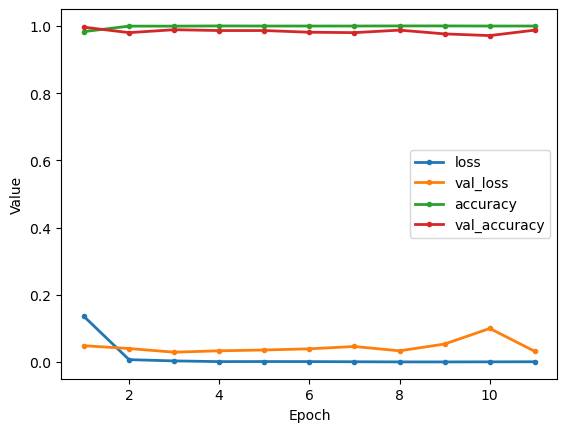

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

14/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/G2-like/report_IQ3B2NKV.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################